In [1]:
import h5py
import numpy as np 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM 
from redrock.external import desi
from redrock.templates import Template

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
f_galtemp = ''.join(['/Users/chang/projects/packages/redrock-templates/rrtemplate-galaxy.fits'])
temp = Template(filename=f_galtemp)

DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


In [4]:
emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
emline_lambda = [3727.092, 3729.874, 4862.683, 4960.295, 5008.239, 6302.046, 6365.535, 6549.852, 6564.613, 6585.277, 6718.294, 6732.673]

(-0.02, 0.02)

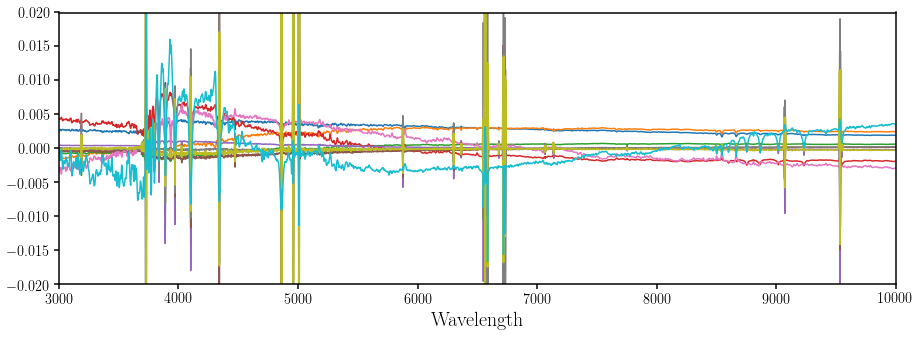

In [5]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for i in range(temp.flux.shape[0]):
    sub.plot(temp.wave, temp.flux[i])
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3e3, 1e4])
sub.set_ylim([-0.02, 0.02])

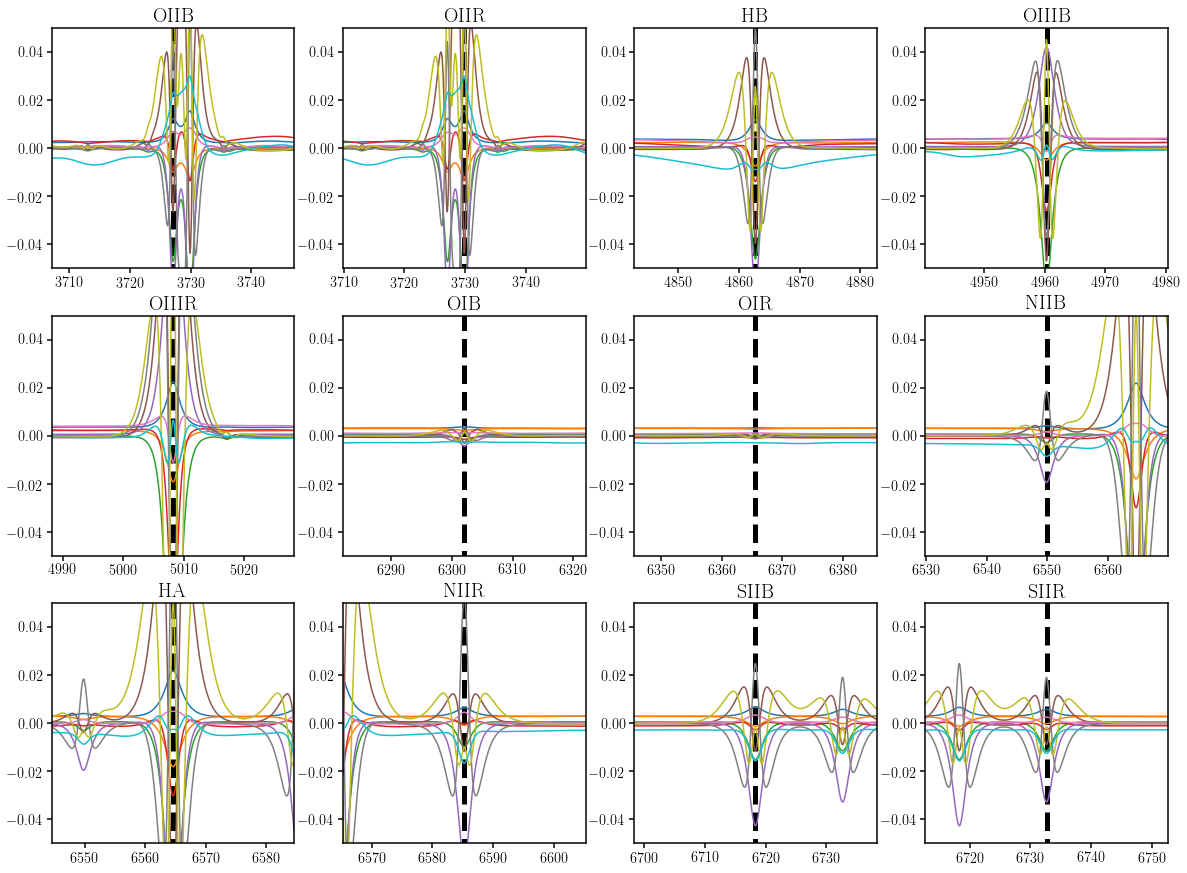

In [6]:
fig = plt.figure(figsize=(20,15))
for i_l, lam in enumerate(emline_lambda): 
    sub = fig.add_subplot(3,4,i_l+1)
    for i in range(temp.flux.shape[0]):
        sub.plot(temp.wave, temp.flux[i])
    sub.vlines(lam, -0.1, 0.1, linewidth=5, linestyle='--')
    sub.set_title(emline_keys[i_l].upper(), fontsize=20)
    sub.set_xlim([lam-20, lam+20])
    sub.set_ylim([-0.05, 0.05])

In [7]:
f_spec = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/',
                       'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.fits'])
target = desi.DistTargetsDESI(f_spec)._my_data

In [8]:
fblock = h5py.File(''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/',
                            'gleg.g15.darksky.seed1.exptime300.1of13blocks.hdf5']), 'r')

In [9]:
gama_ha = fblock['gama-spec']['ha_flux'].value
zred = fblock['gama-spec']['z'].value
print np.where(gama_ha > 1e3)[0][:10]
print zred[:10]

[ 0  9 29 32 35 48 77 84 85 93]
[0.125284   0.31862774 0.23001106 0.2728309  0.23246159 0.05463286
 0.22040227 0.29020756 0.16156642 0.13569   ]


(-5.0, 30.0)

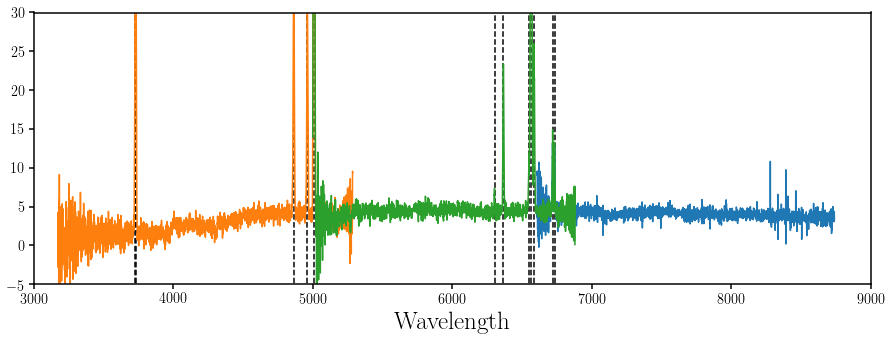

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for s in target[0].spectra: 
    sub.plot(s.wave/(1.+zred[0]), s.flux)
for i_l, lam in enumerate(emline_lambda): 
    sub.vlines(lam, -10., 160., linestyle="--")
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3e3, 9e3])
sub.set_ylim([-5., 30.])

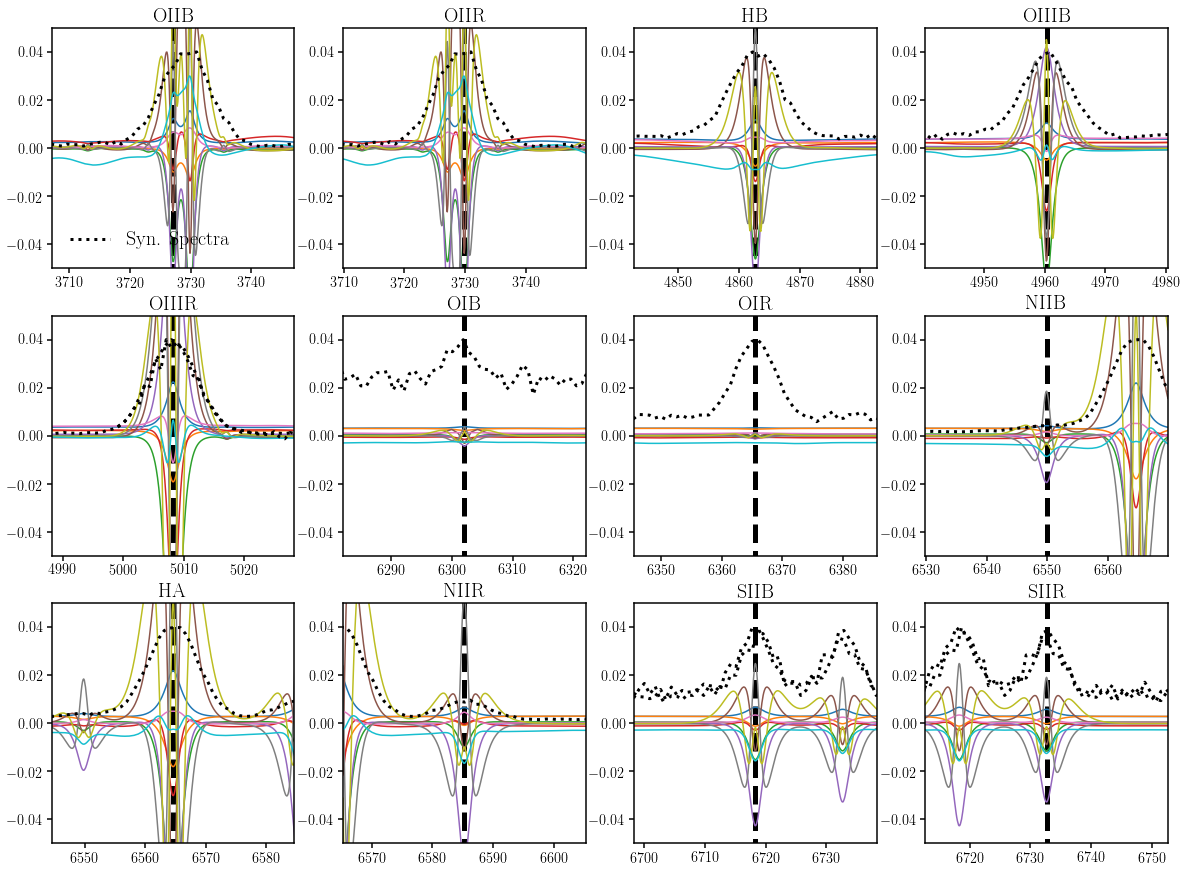

In [11]:
fig = plt.figure(figsize=(20,15))
for i_l, lam in enumerate(emline_lambda): 
    sub = fig.add_subplot(3,4,i_l+1)
    for i in range(temp.flux.shape[0]):
        sub.plot(temp.wave, temp.flux[i])
    for s in target[0].spectra: 
        inbin = (s.wave/(1.+zred[0]) > lam-20.) & (s.wave/(1.+zred[0]) < lam+20)
        if np.sum(inbin) > 0: 
            sub.plot(s.wave/(1.+zred[0]), s.flux/np.max(s.flux[inbin])*0.04, c='k', ls=':', lw=3, 
                     label='Syn. Spectra')
            
    if i_l == 0: sub.legend(fontsize=20)
    sub.vlines(lam, -0.1, 0.1, linewidth=5, linestyle='--')
    sub.set_title(emline_keys[i_l].upper(), fontsize=20)
    sub.set_xlim([lam-20, lam+20])
    sub.set_ylim([-0.05, 0.05])

In [12]:
cata = Cat.GamaLegacy()
gleg = cata.Read('g15', dr_gama=3, dr_legacy=7)
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.


In [13]:
s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=2e4)
emline_flux = s_bgs.EmissionLineFlux(gleg, index=np.array([0]), dr_gama=3)

INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


In [14]:
emline_flux.max()

1574.3199435635245

In [15]:
redshift = gleg['gama-spec']['z']
r_mag_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
r_mag_gama = gleg['gama-photo']['modelmag_r']
vdisp = np.repeat(100., 1)
flux_eml, wave, _, magnorm_flag = s_bgs.Spectra(r_mag_apflux[0], np.array(redshift[0]), np.array(100.), 
                                      templateid=match[0], emflux=emline_flux, 
                                      seed=1, mag_em=[r_mag_gama[0]], silent=False)
print magnorm_flag

[ True]


(-5.0, 30.0)

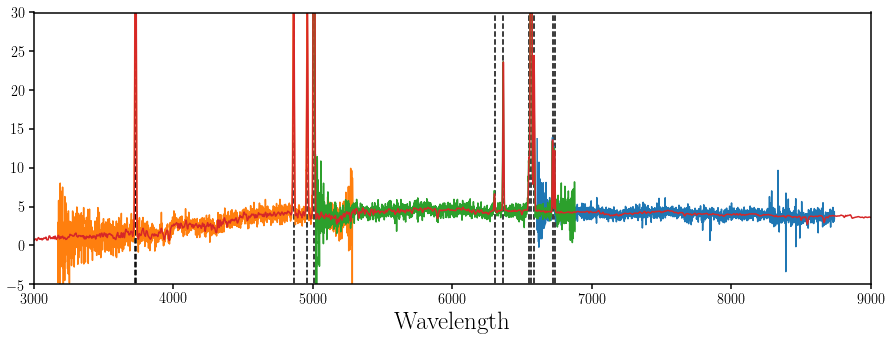

In [16]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for s in target[0].spectra: 
    sub.plot(s.wave/(1.+zred[0]), s.flux)
for i_l, lam in enumerate(emline_lambda): 
    sub.vlines(lam, -10., 160., linestyle="--")
sub.plot(wave/(1.+redshift[0]), flux_eml[0])
#sub.plot(s_bgs.basewave.astype(float), emline_flux[0,:] * 10**17)
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3e3, 9e3])
sub.set_ylim([-5., 30.])

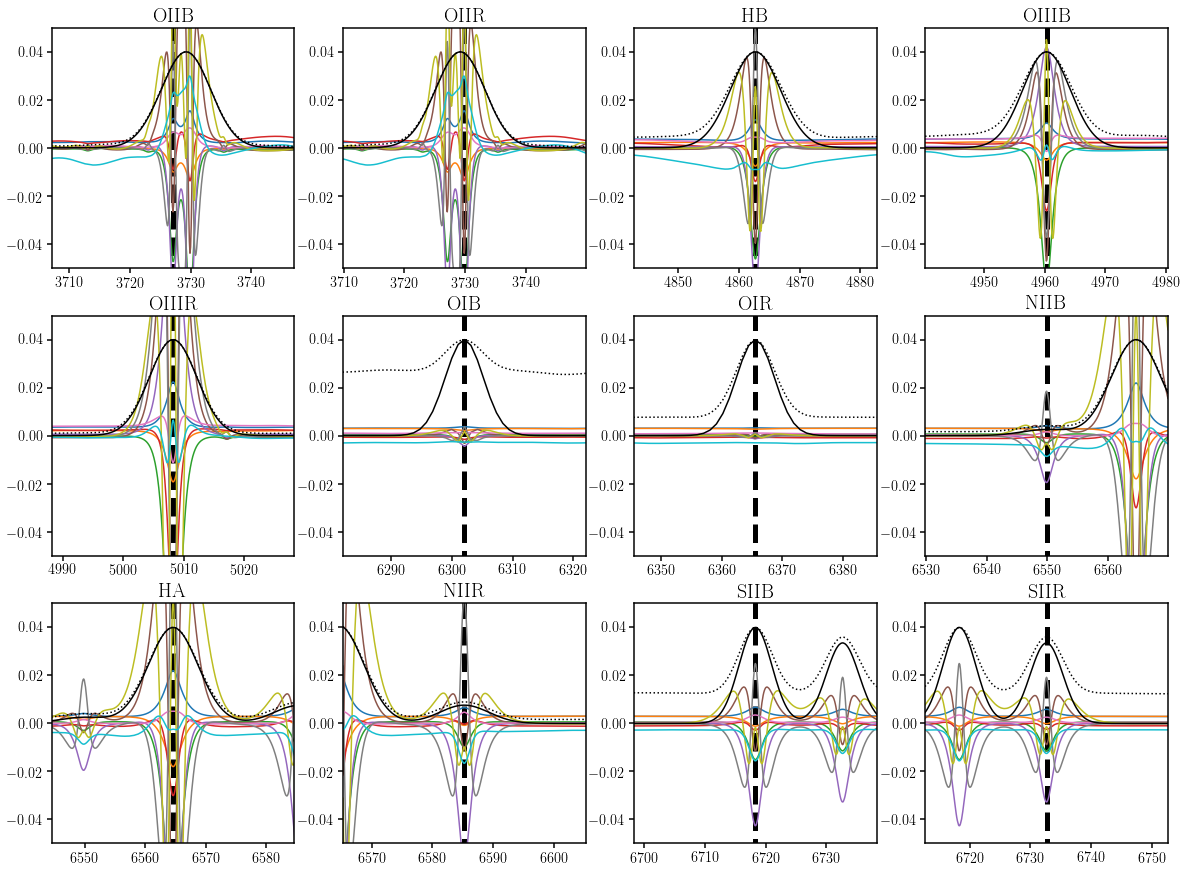

In [17]:
fig = plt.figure(figsize=(20,15))
for i_l, lam in enumerate(emline_lambda): 
    sub = fig.add_subplot(3,4,i_l+1)
    for i in range(temp.flux.shape[0]):
        sub.plot(temp.wave, temp.flux[i])
    inbin = (wave / (1+redshift[0]) > lam-20.) & (wave / (1+redshift[0]) < lam+20.)
    sub.plot(wave/(1.+redshift[0]), flux_eml[0]/np.max(flux_eml[0][inbin])*0.04, c='k', ls=':')
            
    inbin = (s_bgs.basewave.astype(float) > lam-20.) & (s_bgs.basewave.astype(float) < lam+20.)
    if np.sum(inbin) > 0: 
        sub.plot(s_bgs.basewave.astype(float),
                 emline_flux[0,:]/np.max(emline_flux[0,inbin])*0.04, c='k')
    if i_l == 0: sub.legend(fontsize=20)
    sub.vlines(lam, -0.1, 0.1, linewidth=5, linestyle='--')
    sub.set_title(emline_keys[i_l].upper(), fontsize=20)
    sub.set_xlim([lam-20, lam+20])
    sub.set_ylim([-0.05, 0.05])

In [18]:
fdesi = FM.fakeDESIspec()
bgs_spectra = fdesi.simExposure(wave, flux_eml, skycondition='dark', exptime=300)

(-5.0, 30.0)

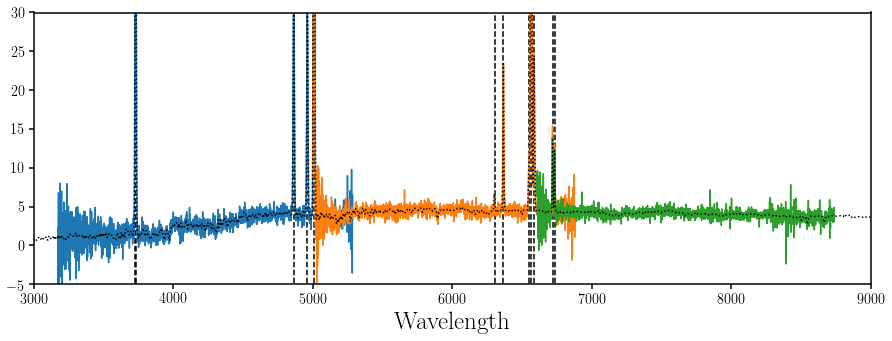

In [25]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for b in bgs_spectra.bands: 
    sub.plot(bgs_spectra.wave[b]/(1.+zred[0]), bgs_spectra.flux[b][0])
for i_l, lam in enumerate(emline_lambda): 
    sub.vlines(lam, -10., 160., linestyle="--")
sub.plot(wave/(1.+redshift[0]), flux_eml[0], c='k', ls=':')
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3e3, 9e3])
sub.set_ylim([-5., 30.])

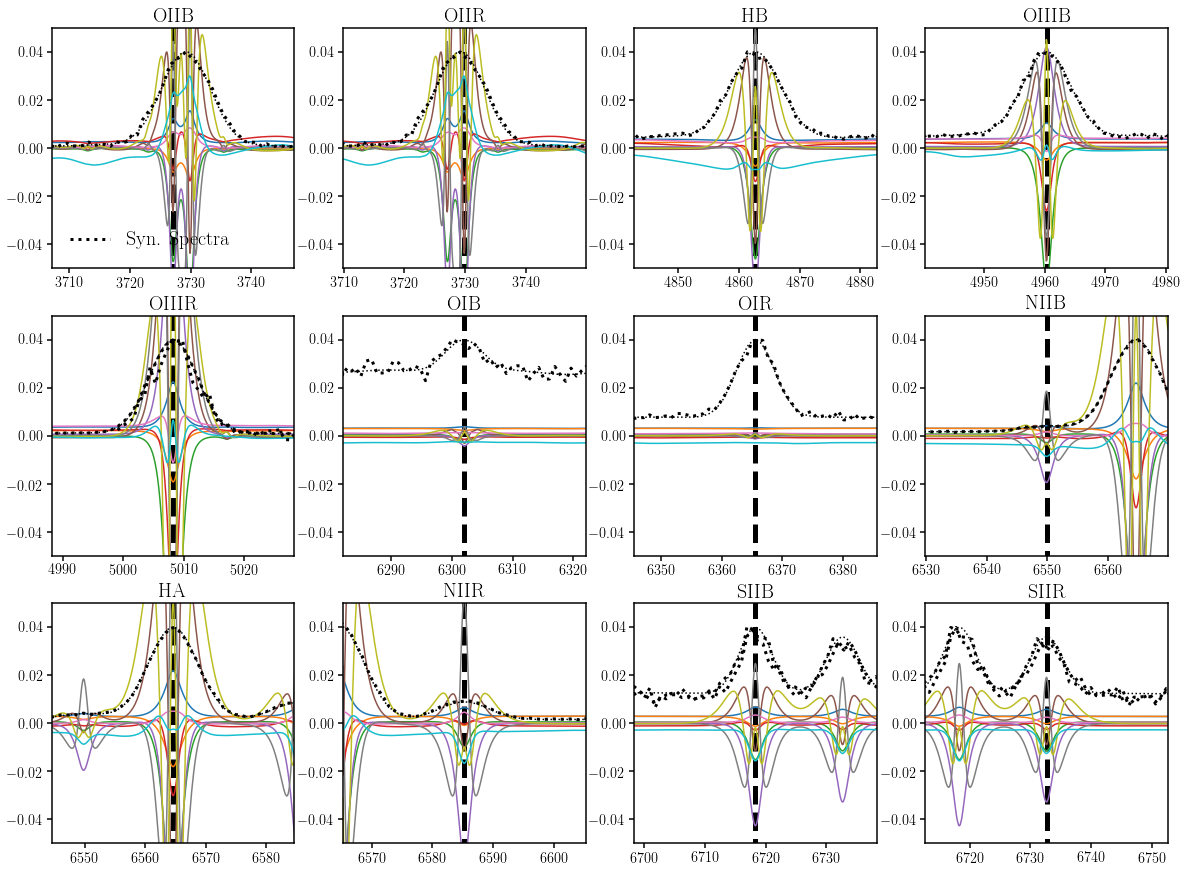

In [30]:
fig = plt.figure(figsize=(20,15))
for i_l, lam in enumerate(emline_lambda): 
    sub = fig.add_subplot(3,4,i_l+1)
    for i in range(temp.flux.shape[0]):
        sub.plot(temp.wave, temp.flux[i])
    for b in bgs_spectra.bands: 
        w = bgs_spectra.wave[b].copy()
        fl = bgs_spectra.flux[b][0].copy()
        inbin = (w/(1.+redshift[0]) > lam-20.) & (w/(1.+redshift[0]) < lam+20)
        if np.sum(inbin) > 0: 
            sub.plot(w/(1.+redshift[0]), fl/np.max(fl[inbin])*0.04, c='k', ls=':', lw=3, label='Syn. Spectra')

    inbin = (wave / (1+redshift[0]) > lam-20.) & (wave / (1+redshift[0]) < lam+20.)
    sub.plot(wave/(1.+redshift[0]), flux_eml[0]/np.max(flux_eml[0][inbin])*0.04, c='k', ls=':')
                    
    if i_l == 0: sub.legend(fontsize=20)
    sub.vlines(lam, -0.1, 0.1, linewidth=5, linestyle='--')
    sub.set_title(emline_keys[i_l].upper(), fontsize=20)
    sub.set_xlim([lam-20, lam+20])
    sub.set_ylim([-0.05, 0.05])